In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cm
import networkx as nx
from tqdm import tqdm
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score

import utils

%config InlineBackend.figure_format = 'retina'

default_cluster_eps = 0.021
default_cluster_samples = 10

lower_cluster_eps = 0.012
lower_min_samples = 10

In [ ]:
# Read in graph stats including cc, gamma and degree
graph_stats = pd.read_csv("gammas_telenor.csv", index_col=0, header=0)

# Load Bitcoin OTC embeddings
s2v_2  = pd.read_csv('../struc2vec/emb/telenor-2dims.emb', sep=' ', skiprows=[0], names=['ids', 'X', 'Y'])
s2v_50 = pd.read_csv('emb/2d/s2v_50dim_telenor.csv', header=None, names=['ids', 'X', 'Y'])
s2v_100 = pd.read_csv('emb/2d/s2v_100dim_telenor.csv', header=None, names=['ids', 'X', 'Y'])
s2v_300 = pd.read_csv('emb/2d/s2v_300dim_telenor.csv', header=None, names=['ids', 'X', 'Y'])

# Load Telenor embeddings
n2v_2 = pd.read_csv('../node2vec/emb/n2v_2dim_telenor.emb', skiprows=[0], sep=" ", header=None, names=['ids', 'X', 'Y'])

# Load baseline
baseline_df = pd.read_csv('emb/3d/baseline_telenor.csv', sep=' ', skiprows=[0], header=None, names=['ids', 'X', 'Y'])

# Read in original graph
edge_list = pd.read_csv('../struc2vec/graph/telenor-undirected.edgelist', sep=' ', names=['from', 'to'])
G = nx.from_pandas_edgelist(edge_list, 'from', 'to')

In [ ]:
#Plot TSNE cluster with cc as color

embeddings = []
for i, emb in enumerate([s2v_10]):
    emb_copy = emb.copy(deep=True).set_index("ids")
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_emb = scaler.fit_transform(emb_copy)
    emb_copy['X'] = scaled_emb[:, 0]
    emb_copy['Y'] = scaled_emb[:, 1]
    
    # Add clusters and graph data
    emb_copy = utils.enhance_with_clusterings(emb_copy, eps=default_cluster_eps, min_samples=default_cluster_samples)
    emb_copy = emb_copy.join(graph_stats)
    
    # Add means of neighbor degrees
    avg_neighbor_degrees = nx.neighbor_degree.average_neighbor_degree(G)
    mean_neighborhood_degrees = pd.DataFrame({'Neighbor Degrees': [avg_neighbor_degrees[node] for node in emb_copy.index.values]}, index=emb_copy.index.values)
    emb_copy = emb_copy.join(mean_neighborhood_degrees)

    # Filter to show only certain clusters
    #emb_copy = emb_copy[emb_copy['Cluster'].apply(lambda cluster: cluster in [36, 37, 41, 2])]
    #emb_copy = emb_copy[emb_copy['Cluster'].apply(lambda cluster: cluster in [1, 40 ,39])]
    #emb_copy = emb_copy[emb_copy['Cluster'].apply(lambda cluster: cluster in [28])]
    
    # Filter to show only certain degrees
    #emb_copy = emb_copy[emb_copy['Node Degree'] < 10]
    
    # Plot settings
    log_norm = utils.get_norm(num_colors=emb_copy['Node Degree'].max(), logarithmic=True, vmin=1.0)
    cmap = 'gnuplot'
    save_prefix = 'img/tsne_telenor_300dim'
    save = False
    
    # Plot TSNE with clusters
    manual_annotate = {0: (0.43, 0.22)}
    utils.show_clusters(emb_copy, cluster_labels=False, save=save, save_prefix='{}_cluster.png'.format(save_prefix))
    
    # Show node degree
    utils.show_embedding_plot(emb_copy, color_col='Node Degree', cmap=cmap, norm=log_norm, save=save, savefile='{}_degree.png'.format(save_prefix))
    
    # Show neighbor degrees
    #utils.show_embedding_plot(emb_copy, color_col='Neighbor Degrees', cmap=cmap, save=save, norm=log_norm, savefile='{}_neighbormean'.format(save_prefix))
    
    # Show cluster coefficient
    utils.show_embedding_plot(emb_copy, color_col='Cluster Coefficient', cmap=cmap, save=save, savefile='{}_cc.png'.format(save_prefix))
    
    # Show gamma
    utils.show_embedding_plot(emb_copy, color_col='Gamma', cmap=cmap, save=save, savefile='{}_gamma.png'.format(save_prefix))
    
    # For calculation of Rand index
    embeddings.append(emb_copy)

if len(embeddings) >= 2:
    baseline_clusters = embeddings[0].sort_index()['Cluster'].values
    other_clusters = embeddings[1].sort_index()['Cluster'].values

    adj_rand = adjusted_rand_score(baseline_clusters, other_clusters)
    adj_mutinfo = adjusted_mutual_info_score(baseline_clusters, other_clusters)

    print("Adjusted Rand index: {}".format(adj_rand))

In [11]:
#clusters = [utils.get_cluster_members_index(clustered_embeddings, i) for i in [0, 1, 3]]
#cluster_neighbors = []
#for cluster in clusters:
#    neighbors = []
#    for node in cluster:
#        print(node)
#        print()
#        source, dest = list(G.edges(node))[0]
#        neighbor = source if source != node else dest
#        neighbors.append(neighbor)
#    cluster_neighbors.append(neighbors)
#
#for i, neighbors in enumerate(cluster_neighbors):
#    degrees, ccs, gammas = [], [], []
#    for node in neighbors:
#        egograph = nx.ego_graph(G, node)
#        degrees.append(utils.get_degree(egograph, node))
#        ccs.append(nx.clustering(egograph, node))
#        gammas.append(utils.gamma(egograph, node))
#    print("Cluster {}".format(i))
#    print("Mean degree {}".format(np.mean(degrees)))
#    print("Mean cc {}".format(np.mean(ccs)))
#    print("Mean gamma {}".format(np.mean(gammas)))
#    
#    print("Median degree {}".format(np.median(degrees)))
#    print("Median cc {}".format(np.median(ccs)))
#    print("Median gamma {}".format(np.median(gammas)))

{4481535}
81

{3535884}
113



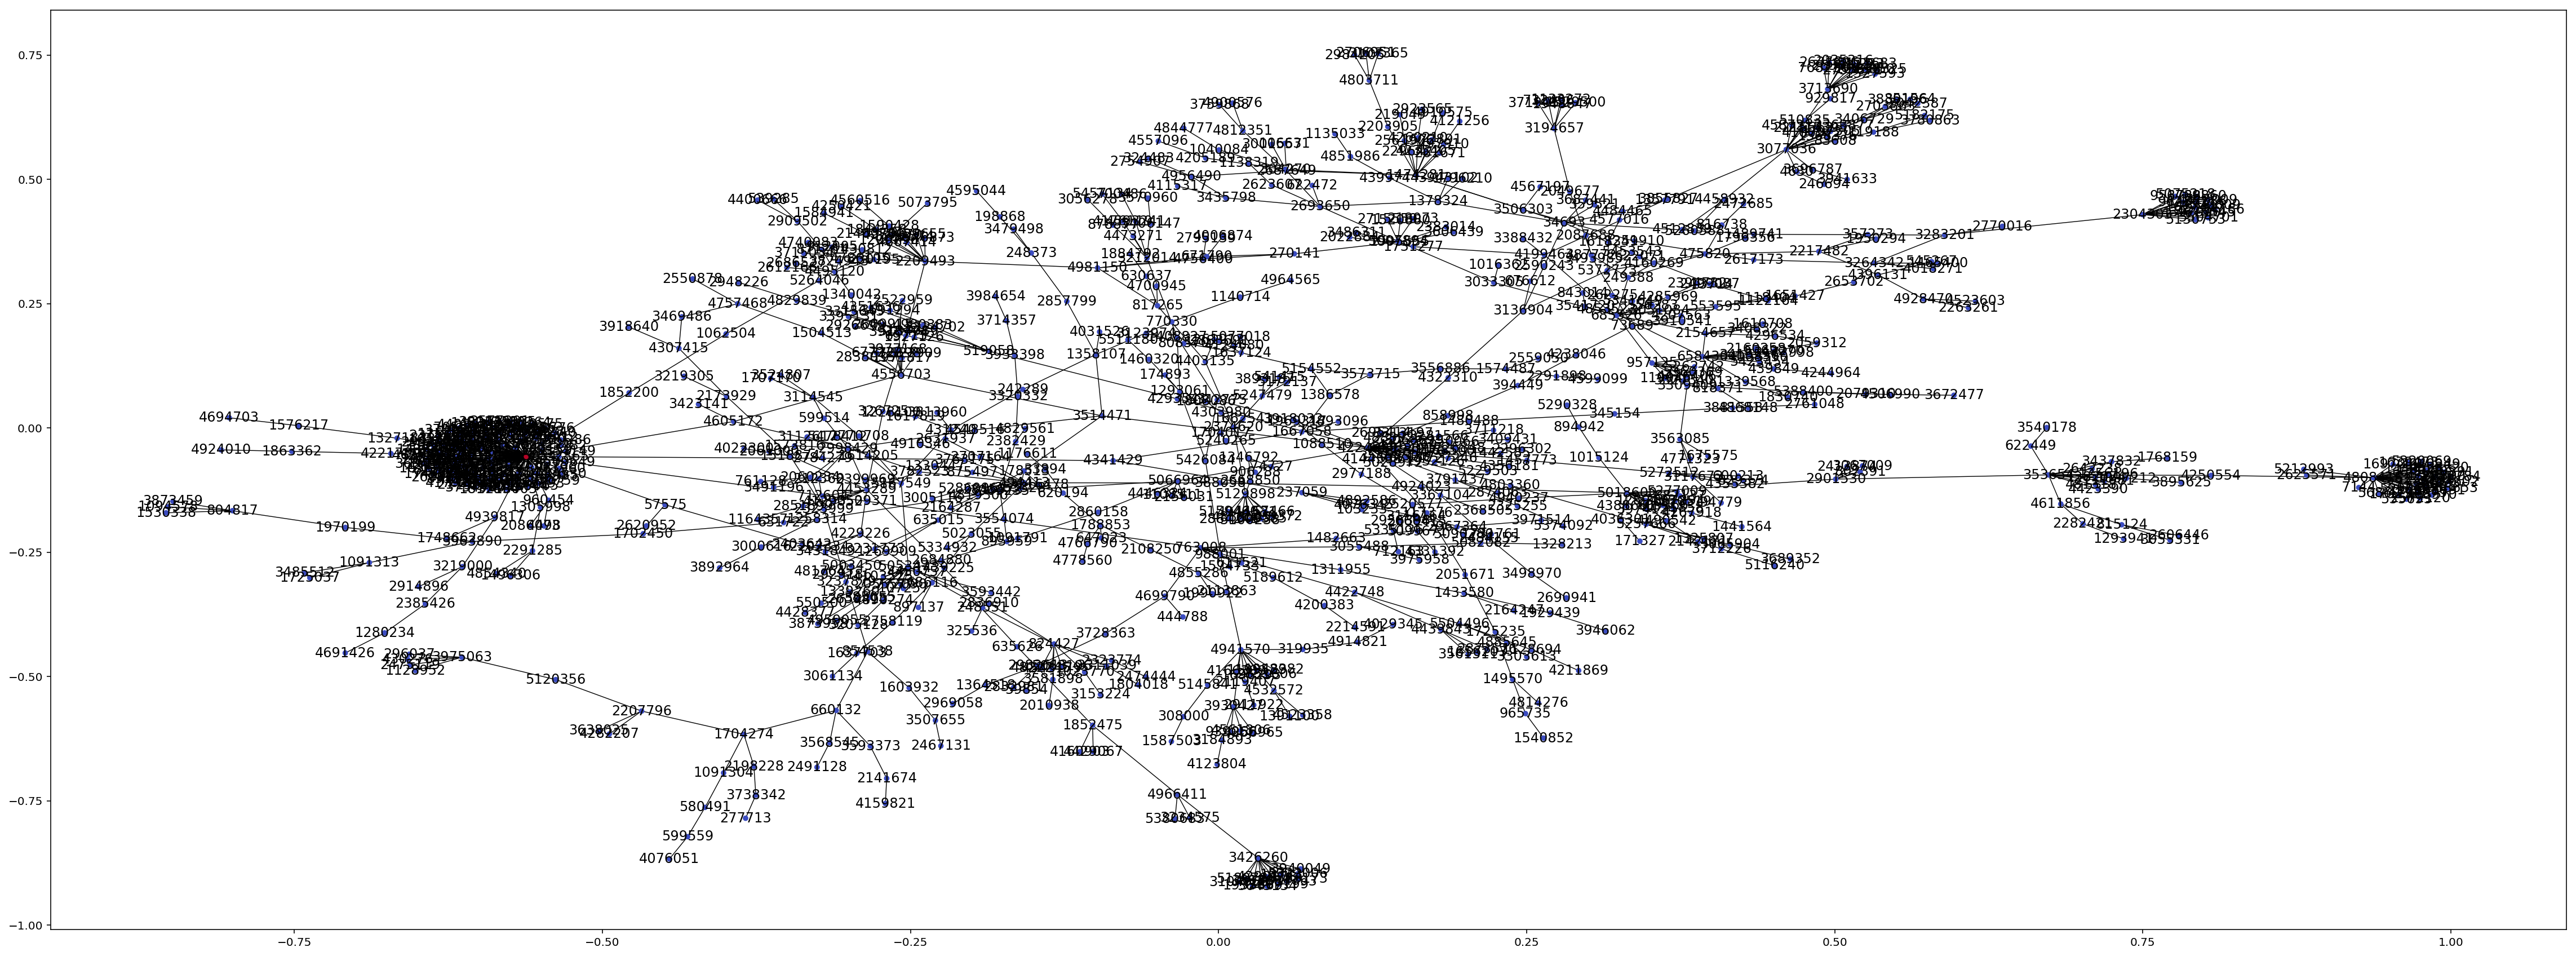

In [13]:
clusters = [utils.get_cluster_members_index(emb_copy, i) for i in [2, 3]]
min_len = min(list(map(lambda cluster: len(cluster), clusters)))
min_len = 10
#clusters = list(map(lambda cluster: cluster[min_len:min_len+10], clusters))


for nodes in clusters:
    neighbors = []
    for node in nodes:
        source, dest = list(G.edges(node))[0]
        neighbor = source if source != node else dest
        neighbors.append(neighbor)
    print(set(neighbors))
    print(len(neighbors))
    print()

utils.draw_subgraph(nx.ego_graph(G, 3535884, radius=12), 3535884)
    
#i = 0
#for nodes in zip(*clusters):
#    utils.create_egograph_comparison(G, nodes, i, radius=2)
#    i += 1